### Import Necessary Packages and download the csv files

#### Importing packages

In [2]:
# import packages
import pandas as pd
import pandas_profiling as pd_prof
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for downloading file
from google.colab import files

## Use random forest to create and evaluate new model
from sklearn.ensemble import RandomForestClassifier

In [3]:
!pip install astroquery

In [4]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


#### Finding GAIA Data

In [5]:
## making a GAIA cone_search of 30m radius around NGC3766 center

coordinate = coord.SkyCoord.from_name('NGC3766')
print(coordinate)
radius = u.Quantity(0.8, u.deg)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coordinate, radius)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (174.075, -61.615)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [6]:
## save the ASCII table as a panadas dataframe
all_stars = r.to_pandas()
all_stars

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
0,1635721458409799680,Gaia DR2 5334208201785186560,5334208201785186560,595460342,2015.5,174.073642,0.472828,-61.614653,0.250960,-0.695449,0.411972,-1.688097,-11.868175,0.996948,4.197831,0.505422,-0.138907,-0.265170,0.282489,-0.419210,0.003054,-0.347333,0.090266,0.291185,0.171235,-0.225816,131,0,130,1,-0.234029,120.683662,0.000000,0.000000,31,False,0.190621,1.401700,0.086980,0.073929,...,522.328609,23.609277,22.123871,17.967060,2.410011,0,0.979300,-0.327131,1.306431,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.125669,-0.034392,212.815523,-55.761049,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.000741
1,1635721458409799680,Gaia DR2 5334208304865630208,5334208304865630208,648553357,2015.5,174.074696,5.327171,-61.613932,3.187506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.208444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,0,38,1,3.163009,64.891205,7.387883,9.836476,3,False,0.008789,NaN,NaN,-0.327540,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.125943,-0.033558,212.815255,-55.760184,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.001082
2,1635721458409799680,Gaia DR2 5334208304864405248,5334208304864405248,111246398,2015.5,174.077325,0.109879,-61.615129,0.069090,0.391415,0.099926,3.917049,-9.930170,0.231860,2.452449,0.148982,-0.235604,-0.222603,-0.553335,0.216787,0.084098,0.330659,-0.282677,0.064832,0.371071,-0.242430,157,0,156,1,0.639170,161.683411,0.198162,0.863255,31,False,2.588396,1.540610,0.019658,0.007752,...,2444.931311,36.529465,66.930389,16.291254,1.428980,0,1.029282,0.270058,0.759224,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.127483,-0.034347,212.818331,-55.760157,102001,5215.174805,4805.0,5754.333496,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.001105
3,1635721458409799680,Gaia DR2 5334208201785179648,5334208201785179648,1506337893,2015.5,174.074270,0.325136,-61.616094,0.276855,0.555246,0.332560,1.669611,-4.874109,0.604785,1.538106,0.593330,-0.210834,-0.272371,-0.568558,0.187147,-0.140817,0.268885,-0.147709,0.160472,0.173339,-0.073803,148,0,147,1,3.456599,207.719818,1.110453,2.527485,31,False,0.208933,1.492084,0.077694,0.155023,...,693.228738,37.596551,18.438625,17.659729,2.028401,0,1.270449,0.040741,1.229708,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.126368,-0.035688,212.817701,-55.761864,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.001147
4,1635721458409799680,Gaia DR2 5334208201786103680,5334208201786103680,1035601844,2015.5,174.078111,5.318735,-61.615813,

##### Applying Filter:

In [160]:
all_stars_filtered = all_stars[all_stars['parallax_over_error'] > 3]

In [161]:
all_stars_filtered = all_stars_filtered[(all_stars_filtered['pmdec_over_error'] > 3) & (all_stars_filtered['pmra_over_error'] > 3)]

In [162]:
all_stars_filtered.shape

(88492, 99)

##### Visualizing GAIA data

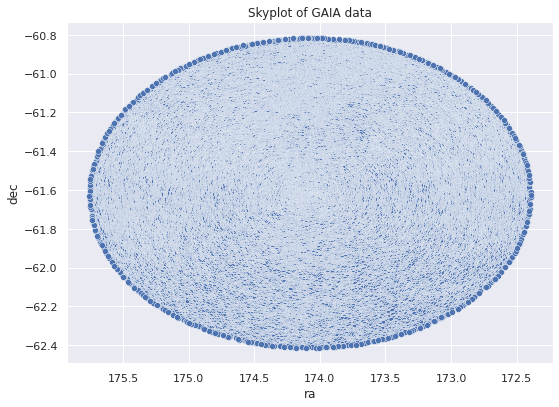

In [377]:
## plotting the skyplot 

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', 
                          data = all_stars_filtered)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()

#### Finding Cantat Data

In [35]:
#### Finding Cantat catalogue

catalog_list = Vizier.find_catalogs('Cantat')
{k:v.description for k,v in catalog_list.items()}

{'I/349': 'StarHorse, Gaia DR2 photo-astrometric distances (Anders+, 2019)',
 'J/A+A/561/A94': 'Velocities and photometry in Trumpler 20 (Donati+, 2014)',
 'J/A+A/564/A133': 'Gaia FGK benchmark stars: metallicity (Jofre+, 2014)',
 'J/A+A/569/A17': 'Gaia-ESO Survey: NGC6705 (Cantat-Gaudin+, 2014)',
 'J/A+A/582/A81': 'Gaia FGK benchmark stars: abundances (Jofre+, 2015)',
 'J/A+A/588/A120': 'Equivalent widths in 10 open clusters (Cantat-Gaudin+, 2016)',
 'J/A+A/591/A37': 'Gaia-ESO Survey. Parameters for cluster members (Jacobson+, 2016)',
 'J/A+A/597/A10': 'South Ecliptic Pole stars radial velocities (Fremat+, 2017)',
 'J/A+A/598/A68': 'Gaia-ESO Survey. Trumpler 23 (Overbeek+, 2017)',
 'J/A+A/601/A19': 'Gaia DR1 open cluster members (Gaia Collaboration+, 2017)',
 'J/A+A/603/A2': 'Gaia-ESO Survey abundances radial distribution (Magrini+, 2017)',
 'J/A+A/605/A79': 'TGAS Cepheids and RR Lyrae stars (Gaia Collaboration+, 2017)',
 'J/A+A/615/A49': 'TGAS stars membership in 128 open clusters (C

In [36]:
## cheking the tables in the GAIA DR2 paper

Vizier.ROW_LIMIT = -1
#catalogs = Vizier.get_catalogs(catalog_list['J/A+A/633/A99'])
#catalogs

In [163]:
## saving only NGC 3766 data from Cantat GAIA DR2 paper

cantat_3766 = Vizier(catalog = 'J/A+A/633/A99/members', row_limit = -1).query_constraints(Cluster="NGC_3766")
cantat_3766 = cantat_3766[0].to_pandas()
cantat_3766

,RA_ICRS,DE_ICRS,Source,Plx,pmRA,pmDE,RV,Gmag,BP-RP,Proba,Cluster,_RA.icrs,_DE.icrs
0,174.195211,-61.479252,5335665295192871936,0.4705,-7.012,1.041,NaN,17.737400,1.1943,0.5,NGC_3766,174.195274,-61.479256
1,174.521895,-61.604049,5335659140506554752,0.4452,-6.705,0.834,NaN,17.822300,1.4727,0.2,NGC_3766,174.521956,-61.604052
2,174.447990,-61.635711,5335658831266493056,0.3478,-6.265,0.635,NaN,16.277500,0.9769,0.1,NGC_3766,174.448046,-61.635713
3,174.516866,-61.556410,5335660961569919232,0.4432,-6.704,0.777,NaN,12.143400,0.1415,0.3,NGC_3766,174.516927,-61.556414
4,174.439503,-61.377736,5335671205118524288,0.4133,-6.378,0.567,NaN,14.920500,0.9065,0.1,NGC_3766,174.439560,-61.377738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,173.832089,-61.545743,5334212496766217088,0.4893,-6.506,1.006,NaN,15.071000,0.7857,0.9,NGC_3766,173.832147,-61.545747
1391,173.740258,-61.484316,5334213007832344320,0.3333,-6.699,0.714,NaN,17.230101,1.2828,0.1,NGC_3766,173.740318,-61.484319
1392,173.628115,-61.453283,5334214077314246912,0.5075,-6.451,1.631,NaN,15.896900,0.9724,0.1,NGC_3766,173.628173,-61.453290
1393,173.808609,-61.487716,5334213115241584896,0.5697,-6.801,1.315,NaN,17.310301,1.2831,0.3,NGC_3766,173.808671,-61.487721


In [164]:
# renaming the cantat table to match it with gaia_data
cantat_3766 = cantat_3766.rename(columns={'Source':'source_id',
                                          'Proba':'PMemb'})


In [165]:
# taking the subset of only source_id and PMemb
cantat_3766 = cantat_3766.loc[:,['source_id', 'PMemb']]


In [167]:
# join the two table on source_id
cantat_3766 = all_stars_filtered.join(cantat_3766.set_index('source_id'), on='source_id')

In [172]:
# dropping the rows, where we don't have PMemb 
# (i.e. the source id was not in the cantat table)
cantat_3766 = cantat_3766.dropna(subset=['PMemb'])
cantat_3766

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb
7,1635721458409799680,Gaia DR2 5334208304878429184,5334208304878429184,1131689298,2015.5,174.079200,0.038525,-61.612725,0.027951,0.431941,0.040436,10.682202,-6.976923,0.076055,1.098638,0.058655,0.068737,-0.338576,-0.230299,-0.088723,0.129381,0.010359,-0.232264,0.108452,0.233223,0.050619,184,184,184,0,8.822382,402.049103,0.000000,0.000000,31,False,322.265320,1.759862,0.008077,0.002711,...,12.046483,1.191182,0,0.145277,0.026115,0.119162,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.127648,-0.031788,212.816452,-55.757820,102001,9674.000000,9365.000000,9824.000000,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.003024,91.735585,18.730578,1.0
10,1635721458409799680,Gaia DR2 5334208201799207680,5334208201799207680,111178695,2015.5,174.078507,0.034568,-61.617738,0.029462,0.461972,0.037725,12.245805,-6.705430,0.063807,1.195871,0.056996,-0.086070,-0.187057,-0.504295,-0.013300,0.205240,0.081850,-0.236470,0.116135,0.244518,0.098781,203,203,198,5,8.925547,425.700531,0.000000,0.000000,31,False,335.689453,1.756988,0.008680,0.084656,...,11.022589,1.178857,1,0.105139,0.021565,0.083573,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.128769,-0.036686,212.822301,-55.761616,100002,9582.500000,9471.000000,9694.000000,0.4688,0.1140,0.8060,0.2370,0.0580,0.4041,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.003199,105.088982,20.981628,1.0
16,1635721458409799680,Gaia DR2 5334208197475777152,5334208197475777152,887841497,2015.5,174.073881,0.040114,-61.619086,0.034597,0.427450,0.044728,9.556643,-6.723508,0.113323,0.691220,0.080728,-0.003161,-0.001094,-0.104134,0.006200,0.124020,0.015251,-0.129372,0.030571,0.093071,-0.231579,151,151,141,10,10.196207,381.662659,0.064293,1.117645,31,False,144.112106,1.754939,0.010054,-0.166603,...,11.379885,1.190707,0,0.148150,0.027697,0.120454,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.127048,-0.038607,212.821207,-55.764121,102001,9697.666992,9245.250000,9824.000000,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.004118,59.330467,8.562283,0.6
22,1635721458409799680,Gaia DR2 5334208201799203072,5334208201799203072,578588760,2015.5,174.078057,0.072739,-61.619506,0.049836,0.501199,0.051079,9.812325,-6.493202,0.123608,0.741959,0.091304,-0.163163,0.021164,-0.860898,0.157684,0.163004,0.182868,-0.582306,0.017386,0.232234,-0.091188,134,134,134,0,5.982381,249.887863,0.000000,0.000000,31,False,342.676086,1.749100,0.010798,-0.114155,...,11.988286,1.194956,1,0.191898,0.041530,0.150369,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.129071,-0.038441,212.824241,-55.763024,100002,9218.750000,7879.333496,9579.000000,0.6920,0.3582,0.9000,0.3490,0.2287,0.4421,<NA>,NaN,NaN,Na

In [49]:
# saving both cantat and Gaia files as csv
# if you want to save, comment out the next two lines

cantat_3766.to_csv('NGC_3766_cantat.csv')
# all_stars.to_csv('NGC_3766_Gaia_30m.csv')

In [50]:
cantat_3766.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb
count,1.358000e+03,1.358000e+03,1.358000e+03,1358.0,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.0,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,...,1.345000e+03,1345.000000,1345.000000,1345.000000,1344.000000,1358.000000,1344.000000,1344.000000,1345.000000,7.000000,7.000000,1358.000000,7.000000,7.000000,7.0,1358.000000,1358.000000,1358.000000,1358.000000,1126.000000,1126.000000,1126.000000,1126.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,645.0,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,1358.000000,1358.000000,1358.000000,1358.000000
mean,1.635721e+18,5.334617e+18,8.405839e+08,2015.5,174.071575,0.043936,-61.604683,0.041459,0.451233,0.051576,11.326612,-6.728480,0.086189,0.984931,0.077625,0.004731,-0.116806,-0.427590,0.005155,0.173457,0.056225,-0.328121,0.162477,0.191084,0.024606,238.798969,31.706186,237.056701,1.742268,2.200283,312.288391,0.049650,1.380207,31.0,47.418640,1.607744,0.010553,-0.013360,27.382180,16.857879,...,1.994604e+05,1003.554474,413.775513,14.601149,1.268321,0.086156,0.834401,0.315271,0.520156,-4.501915,0.673221,0.047128,4328.571289,3.428571,0.0,294.121919,-0.025329,212.802077,-55.754636,100201.804618,6623.263672,6306.333496,6924.939453,0.759955,0.492425,1.004542,0.378452,0.242196,0.500033,200111.0,3.075979,2.817126,3.384270,77.577660,67.863472,87.291855,0.139595,101.802594,16.334399,0.509423
std,0.000000e+00,6.714607e+14,4.859962e+08,0.0,0.240842,0.023957,0.115445,0.023520,0.059931,0.027627,5.656367,0.271696,0.046871,0.253630,0.046816,0.092069,0.111910,0.112749,0.104203,0.108305,0.097435,0.138586,0.107183,0.110670,0.115644,37.217856,77.424086,37.170668,2.669155,6.144193,275.357025,0.113645,7.564309,0.0,82.129440,0.098413,0.005803,0.061461,4.129504,1.544613,...,2.672622e+06,15842.529115,320.043213,1.802729,0.138848,0.300968,0.468429,0.222054,0.272651,14.147385,0.490243,0.734949,576.524902,0.731925,0.0,0.115537,0.114442,0.207292,0.113302,601.279426,1747.816895,1637.593262,1764.303101,0.324999,0.299344,0.367292,0.161720,0.147130,0.185630,0.0,19.736931,18.306589,22.103130,1102.031494,963.601929,1240.878418,0.083963,50.647096,8.465254,0.296726
min,1.635721e+18,5.334149e+18,4.126710e+05,2015.5,173.417127,0.013413,-61.910596,0.014418,0.332896,0.016530,3.019621,-7.712736,0.025638,0.101040,0.025679,-0.344106,-0.516385,-0.860898,-0.339244,-0.316974,-0.379649,-0.

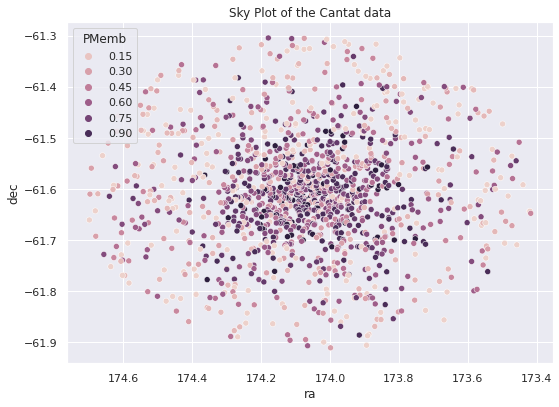

In [379]:
## plotting the skyplot 

skyplot = sns.scatterplot(x = cantat_3766['ra'], y = cantat_3766['dec'], 
                          hue = cantat_3766['PMemb'])
skyplot.invert_xaxis()
plt.title('Sky Plot of the Cantat data')
plt.show()

### Creating, Examining and Processing the Training Data


#### Training Data

In [199]:
# import member dataset
member = cantat_3766.copy()

In [381]:
### adding their distance from the center of the clusters

## NGC 3766
center = coord.SkyCoord.from_name('NGC3766')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((member['ra'] - center_ra)*np.cos(np.radians(member['dec'])))**2 + (member['dec'] - center_dec)**2 )
member['dist_3766_center'] = distance

In [383]:
# maximum distance of stars in Cantat Data
max(member.dist_3766_center)

0.31621627751902387

In [380]:
member['member'] = np.full(len(member), 1)
member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb,dist_3766_center,member
7,1635721458409799680,Gaia DR2 5334208304878429184,5334208304878429184,1131689298,2015.5,174.079200,0.038525,-61.612725,0.027951,0.431941,0.040436,10.682202,-6.976923,0.076055,1.098638,0.058655,0.068737,-0.338576,-0.230299,-0.088723,0.129381,0.010359,-0.232264,0.108452,0.233223,0.050619,184,184,184,0,8.822382,402.049103,0.000000,0.000000,31,False,322.265320,1.759862,0.008077,0.002711,...,0,0.145277,0.026115,0.119162,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.127648,-0.031788,212.816452,-55.757820,102001,9674.000000,9365.000000,9824.00,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.003024,91.735585,18.730578,1,0.003027,1
10,1635721458409799680,Gaia DR2 5334208201799207680,5334208201799207680,111178695,2015.5,174.078507,0.034568,-61.617738,0.029462,0.461972,0.037725,12.245805,-6.705430,0.063807,1.195871,0.056996,-0.086070,-0.187057,-0.504295,-0.013300,0.205240,0.081850,-0.236470,0.116135,0.244518,0.098781,203,203,198,5,8.925547,425.700531,0.000000,0.000000,31,False,335.689453,1.756988,0.008680,0.084656,...,1,0.105139,0.021565,0.083573,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.128769,-0.036686,212.822301,-55.761616,100002,9582.500000,9471.000000,9694.00,0.4688,0.1140,0.806,0.237,0.0580,0.4041,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.003199,105.088982,20.981628,1,0.003206,1
16,1635721458409799680,Gaia DR2 5334208197475777152,5334208197475777152,887841497,2015.5,174.073881,0.040114,-61.619086,0.034597,0.427450,0.044728,9.556643,-6.723508,0.113323,0.691220,0.080728,-0.003161,-0.001094,-0.104134,0.006200,0.124020,0.015251,-0.129372,0.030571,0.093071,-0.231579,151,151,141,10,10.196207,381.662659,0.064293,1.117645,31,False,144.112106,1.754939,0.010054,-0.166603,...,0,0.148150,0.027697,0.120454,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.127048,-0.038607,212.821207,-55.764121,102001,9697.666992,9245.250000,9824.00,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.004118,59.330467,8.562283,1,0.004120,1
22,1635721458409799680,Gaia DR2 5334208201799203072,5334208201799203072,578588760,2015.5,174.078057,0.072739,-61.619506,0.049836,0.501199,0.051079,9.812325,-6.493202,0.123608,0.741959,0.091304,-0.163163,0.021164,-0.860898,0.157684,0.163004,0.182868,-0.582306,0.017386,0.232234,-0.091188,134,134,134,0,5.982381,249.887863,0.000000,0.000000,31,False,342.676086,1.749100,0.010798,-0.114155,...,1,0.191898,0.041530,0.150369,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.129071,-0.038441,212.824241,-55.763024,100002,9218.750000,7879.333496,9579.00,0.6920,0.3582,0.900,0.349,0.2287,0.4421,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.004729,52.530591,8.1

In [384]:
### adding their distance from the center of the clusters

## NGC 3766
center = coord.SkyCoord.from_name('NGC3766')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((all_stars_filtered['ra'] - center_ra)*np.cos(np.radians(all_stars_filtered['dec'])))**2 + (all_stars_filtered['dec'] - center_dec)**2 )
all_stars_filtered['dist_3766_center'] = distance

In [385]:
non_member = all_stars_filtered[all_stars_filtered['dist_3766_center'] >= 0.7].sample(len(member), random_state = 42)

In [386]:
non_member['member'] = np.full(len(non_member), 0)
non_member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,dist_3766_center,member
617823,1635721458409799680,Gaia DR2 5334067361219911552,5334067361219911552,1485257795,2015.5,173.963069,0.024403,-62.397810,0.026290,0.543053,0.030432,17.845013,-7.199559,0.045806,-0.365707,0.049048,-0.006626,-0.135588,-0.363607,0.034692,0.025151,0.064834,-0.339126,0.229853,0.178700,0.052562,300,0,297,3,-3.666178,211.523102,0.000000,0.000000,31,False,12.124643,1.548822,0.006892,-0.049745,...,1.236786,0,1.141031,0.495297,0.645734,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.301066,-0.799419,213.743720,-56.350475,100001,4977.213379,4951.020020,5079.000000,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.675584,1.609097,1.693360,1.552287,1.341949,1.762625,https://gea.esac.esa.int/data-server/datalink/...,,0.784568,157.174318,7.456097,0.784526,0
530949,1635721458409799680,Gaia DR2 5335763907702909568,5335763907702909568,685584120,2015.5,173.544370,0.048282,-60.935932,0.047295,0.401559,0.063844,6.289723,-8.142450,0.091663,0.898640,0.083363,0.057911,-0.166037,-0.391190,0.069381,0.200272,0.148745,-0.070929,0.287029,0.198812,0.090721,291,0,289,2,0.373232,292.308197,0.079807,0.238277,31,False,3.568815,1.512340,0.013093,0.081437,...,1.267171,0,1.237896,0.530428,0.707468,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,293.685101,0.541161,211.652722,-55.454503,100001,4867.000000,4679.490234,5021.680176,0.717,0.259,1.1181,0.353,0.126,0.5461,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.725374,88.830475,10.779859,0.726347,0
624419,1635721458409799680,Gaia DR2 5334887768703069056,5334887768703069056,514673397,2015.5,175.544689,0.067587,-61.989530,0.078370,0.630082,0.101007,6.237980,-5.725657,0.137690,1.645013,0.131754,0.013374,0.010386,-0.321125,0.114564,0.336550,0.182636,-0.055799,0.182267,0.345230,0.010739,237,0,236,1,1.948992,274.726379,0.249715,1.368120,31,False,1.924166,1.550022,0.018283,0.029515,...,1.332509,0,1.234053,0.473362,0.760691,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.897171,-0.203033,214.159219,-55.540007,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.788975,41.583635,12.485483,0.785282,0
547882,1635721458409799680,Gaia DR2 5335742188017827456,5335742188017827456,1616161577,2015.5,173.174670,0.087488,-61.017738,0.073819,0.315781,0.099393,3.177104,-6.366508,0.179986,1.431496,0.134705,-0.139535,-0.035547,-0.453815,0.138151,0.192497,0.156941,-0.138739,0.065031,0.277307,-0.165912,269,0,265,4,1.065108,284.344086,0.119837,0.220189,31,False,1.389606,1.474433,0.021660,0.086228,...,1.366468,0,1.445168,0.586653,0.858515,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,293.538134,0.409761,211.526797,-55.638319,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


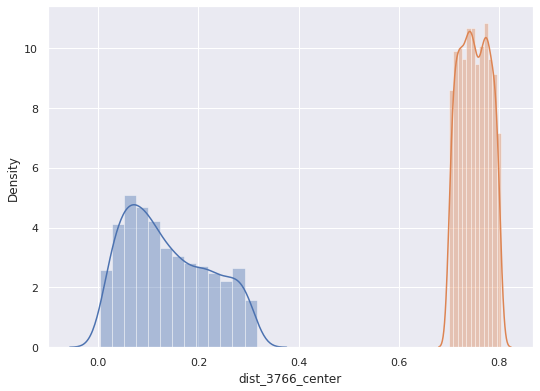

In [388]:
sns.distplot(member['dist_3766_center'])
sns.distplot(non_member['dist_3766_center'])
plt.show()

In [389]:
training_data = pd.concat([member, non_member])

In [390]:
# Examining the descriptive statistics of each column
training_data.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_3766_center,member
count,2.690000e+03,2.690000e+03,2.690000e+03,2690.0,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.0,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,...,2640.000000,2640.000000,2640.000000,2690.000000,2640.000000,2640.000000,2640.000000,24.000000,24.000000,2690.000000,24.000000,24.000000,24.000000,2690.000000,2690.000000,2690.000000,2690.000000,1847.000000,1847.000000,1847.000000,1847.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1056.0,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,2690.000000,2690.000000,2690.000000,1345.0,2690.000000,2690.000000
mean,1.635721e+18,5.334780e+18,8.371501e+08,2015.5,174.084459,0.066992,-61.538229,0.062444,0.558447,0.080791,10.295998,-7.096944,0.136166,1.300539,0.114932,-0.005584,-0.118669,-0.381542,0.007030,0.173548,0.055493,-0.257661,0.175203,0.167158,0.003516,254.173234,18.671375,252.585502,1.587732,2.673294,412.997589,0.163077,4.906309,31.0,31.199852,1.553646,0.016498,-0.012059,29.058364,17.035316,...,354.910004,15.237627,1.325449,0.081784,1.101479,0.433776,0.667703,-6.255727,1.654193,0.058736,4804.166504,3.270833,-0.062500,294.109193,0.037947,212.729208,-55.702968,100162.431511,6000.077637,5729.759766,6298.539062,0.856197,0.595110,1.116244,0.425542,0.293164,0.556680,200111.0,3.108058,2.811337,3.403092,52.026173,45.148445,58.903931,0.444899,94.476621,21.639689,1.0,0.445167,0.500000
std,0.000000e+00,7.120528e+14,4.846834e+08,0.0,0.809550,0.092100,0.375449,0.073639,0.499492,0.100092,8.415555,4.232745,0.188985,2.496381,0.138382,0.093992,0.104941,0.131508,0.100720,0.099614,0.097879,0.151290,0.112455,0.108858,0.128865,35.888641,62.044513,35.944126,2.382516,9.323015,1497.734619,0.496292,53.944471,0.0,68.154724,0.110422,0.019889,0.061136,3.990591,1.480460,...,324.312714,1.769814,0.193937,0.315702,0.530906,0.277126,0.298738,24.357167,2.903980,0.711359,633.471680,0.510310,0.306186,0.389617,0.371503,0.690759,0.371935,544.868348,1653.693848,1552.989746,1670.659302,0.443962,0.431111,0.497621,0.222305,0.213860,0.253555,0.0,15.667116,14.504870,17.539892,862.054138,753.700684,970.745117,0.312023,78.675109,29.346795,0.0,0.312285,0.500093
min,1.635721e+18,5.333378e+18,4.126710e+05,2015.5,172.406209,0.012523,-62.414053,0.012379,0.096016,0.015392,3.010611,-113.169157,0.023667,-69.735741,0.022937,-0.954692,-0.613589,-0.860898,-0.784206,-0.238388,-0.728506,-0.773552,-0.3

In [392]:
# Choosing the features

feature_columns = ['parallax',
                   'pmra', 'pmdec']

features = training_data.loc[:,feature_columns]
targets = training_data['member']

In [393]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# finding where dtype is float64
float64_data = np.where(training_set.dtypes == 'float64')[0] 

# change the data type to float32 from float64
training_set.iloc[:, float64_data] = training_set.iloc[:, float64_data].astype('float32')


# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

,parallax,pmra,pmdec
count,2690.000000,2690.000000,2690.000000
mean,0.558447,-7.096939,1.300540
std,0.499491,4.232746,2.496381
min,0.096016,-113.169159,-69.735741
25%,0.379664,-7.120129,0.846504
50%,0.456162,-6.734682,1.068744
75%,0.535136,-6.378384,1.648697
max,9.502661,19.480213,31.991152


In [398]:
targets.value_counts()

1    1345
0    1345
Name: member, dtype: int64

#### Visualizing Training Data


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


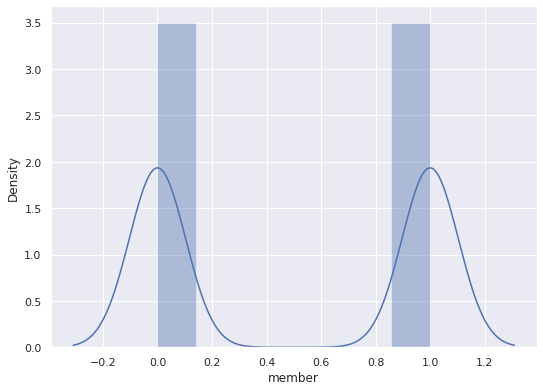

In [396]:
# histogram of PMemb in the training data
sns.distplot(training_set['member'])
plt.show()

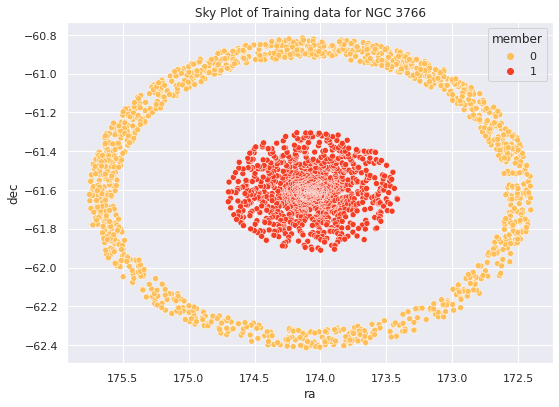

In [399]:
sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x = 'ra', y='dec', palette='YlOrRd', hue = 'member', data = training_data)
skyplot.invert_xaxis()
plt.title('Sky Plot of Training data for NGC 3766')
plt.show()

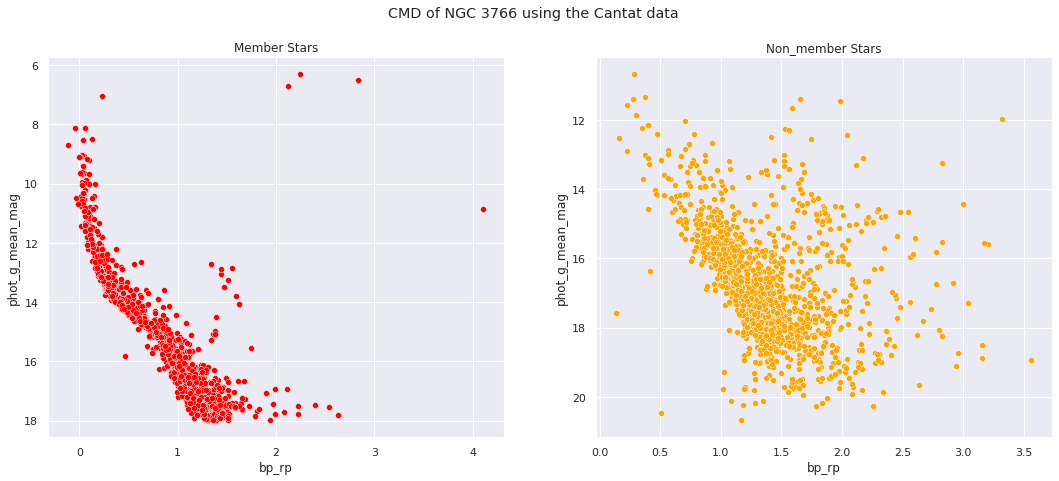

In [371]:
# CMD marked with the membership probabilities of the stars 
# (PMemb >= 0.5 stars are the probable stars)
#cmd = sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', hue = 'PMemb', data = training_data)
#cmd.invert_yaxis()
#plt.title('')
#plt.show()

# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(18,7))
fig.suptitle('CMD of Training data for NGC 3766 ')

sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
axes[0].invert_yaxis()

#plt.show()
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
axes[1].invert_yaxis()

plt.show()


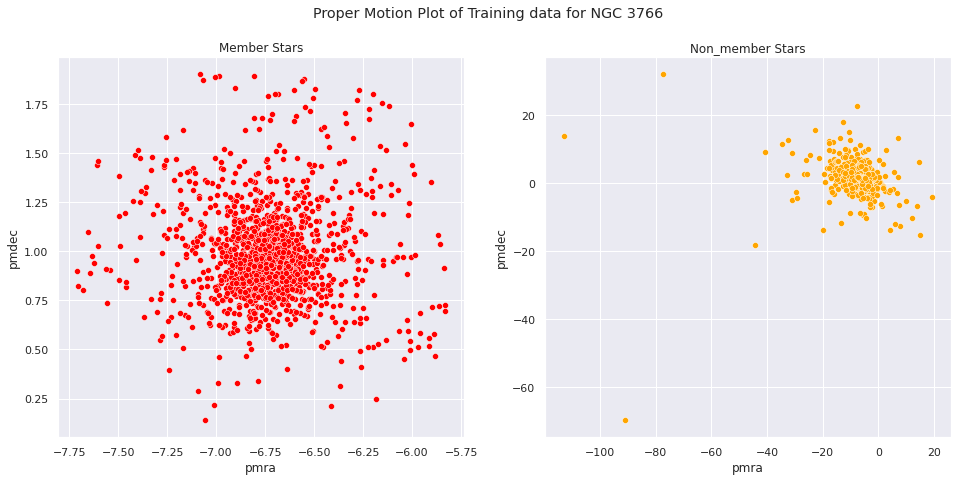

In [561]:
# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('Proper Motion Plot of Training data for NGC 3766 ')

sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
#plt.show()
sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


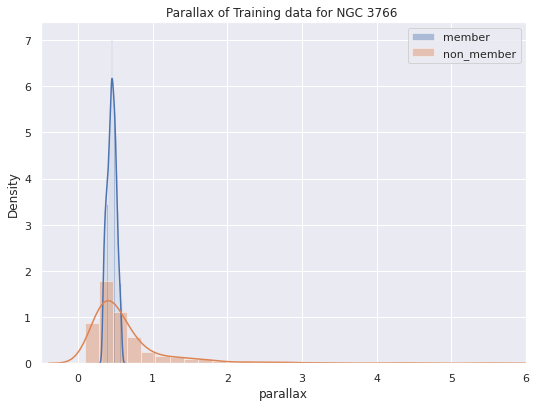

In [400]:
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
plt.xlim(-0.5,6)
plt.title('Parallax of Training data for NGC 3766 ')
plt.legend()
plt.show()

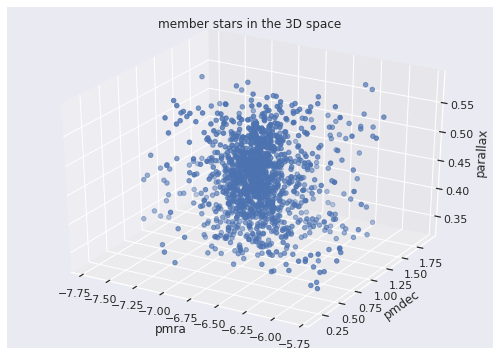

In [401]:
from mpl_toolkits.mplot3d import Axes3D


ax = plt.figure().gca(projection='3d')

ax.scatter(member.pmra, member.pmdec, member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('member stars in the 3D space')
plt.show()


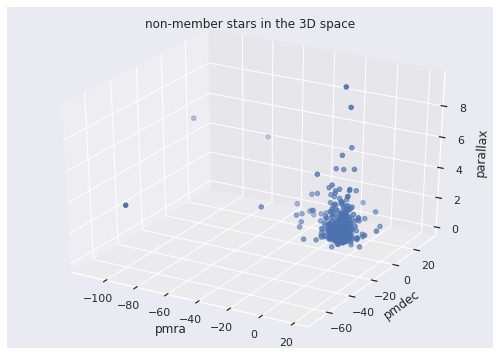

In [402]:
ax = plt.figure().gca(projection='3d')

ax.scatter(non_member.pmra, non_member.pmdec, non_member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('non-member stars in the 3D space')
plt.show()


#### Check Feature Importance using Random Forest

In [403]:
# Use Random Forest on whole dataset using 100 different trees 
rfc = RandomForestClassifier(n_estimators = 100, oob_score = True)
rfc.fit(features, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [404]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

pmra        0.373074
parallax    0.314468
pmdec       0.312458
dtype: float64

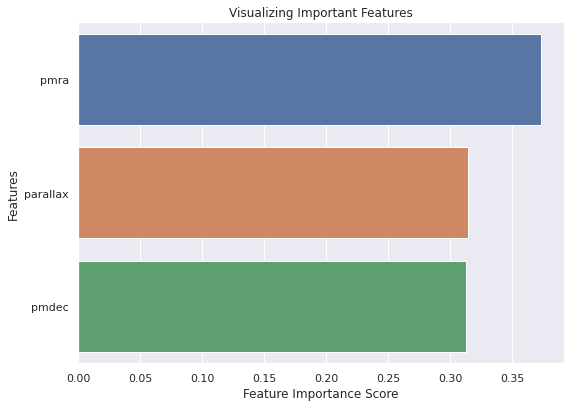

In [405]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Selection and Accuracy Estimate using Test Data

In [441]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report

In [551]:
from sklearn.model_selection import train_test_split
# splitting our dataset using 0.3 test ratio (30% test data, 70% train data)
train_features, test_features, train_targets, test_targets = train_test_split(features, 
                                                                                targets, 
                                                                                test_size = 0.3, 
                                                                                random_state=258)

In [443]:
def evaluate_model(model):
    test_predict = model.predict(test_features)
    train_predict = model.predict(train_features)

    print('Model Accuracy:')
    print("Precision on training data: %.3f" % precision_score(train_targets, train_predict))
    print("Precision on testing data: %.3f" % precision_score(test_targets, test_predict))
    print('Accuracy on test data: %.3f' % accuracy_score(test_targets, test_predict))


    sns.heatmap(confusion_matrix(test_targets, test_predict), cmap= 'Greens', annot = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report: \n", classification_report(test_targets, test_predict))

#### SVC

In [549]:
from sklearn.svm import SVC

# SVC model
svc_clf = SVC(kernel='rbf', gamma = 'scale', random_state=42)

svc_clf.fit(train_features, train_targets)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Model Accuracy:
Precision on training data: 0.751
Precision on testing data: 0.762
Accuracy on test data: 0.838


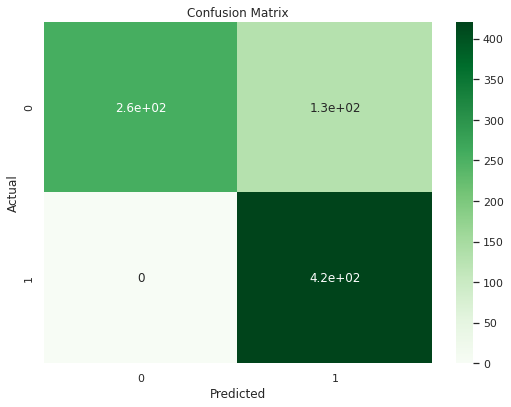

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.66      0.80       387
           1       0.76      1.00      0.87       420

    accuracy                           0.84       807
   macro avg       0.88      0.83      0.83       807
weighted avg       0.88      0.84      0.83       807



In [550]:
evaluate_model(svc_clf)

#### Naive Bayes

Model Accuracy:
Precision on training data: 0.879
Precision on testing data: 0.896
Accuracy on test data: 0.942


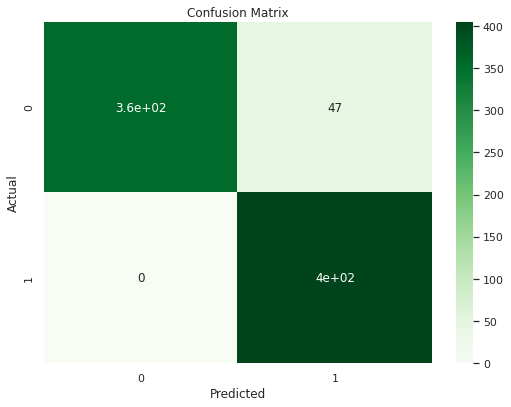

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.94       403
           1       0.90      1.00      0.95       404

    accuracy                           0.94       807
   macro avg       0.95      0.94      0.94       807
weighted avg       0.95      0.94      0.94       807



In [459]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_features, train_targets)
evaluate_model(gnb)

#### KNN

In [446]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score, GridSearchCV

knn_cv = neighbors.KNeighborsClassifier()
parameter_grid = {'n_neighbors': [1,2,3,4,5,6,7,8]}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_cv, parameter_grid, cv=5, scoring='precision')

#fit model to data
knn_gscv.fit(train_features, train_targets)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=0)

In [447]:
# top performance
print("Top Performance: ", knn_gscv.best_params_)
# score for top_performance
print("Top CV score: ", knn_gscv.best_score_)

Top Performance:  {'n_neighbors': 2}
Top CV score:  0.9211235624022134


In [448]:
n_neighbors = 2
knn = neighbors.KNeighborsClassifier(n_neighbors,)
knn.fit(train_features, train_targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.930
Accuracy on test data: 0.913


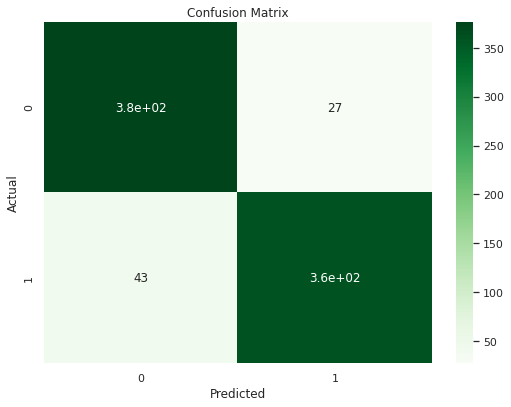

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       403
           1       0.93      0.89      0.91       404

    accuracy                           0.91       807
   macro avg       0.91      0.91      0.91       807
weighted avg       0.91      0.91      0.91       807



In [449]:
evaluate_model(knn)

#### Decision Tree

In [450]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc.fit(train_features, train_targets)
test_predict = dtc.predict(test_features)

In [451]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [452]:
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
np.random.seed(25)
random_states = np.random.choice(range(1,50), size = 10, replace=False)
ccp_alpha = [2**i for i in range(-10,0)]

random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state' : random_states,
               'ccp_alpha': ccp_alpha}

random_grid

{'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'random_state': array([44, 15, 41, 34, 48,  8, 33, 20, 39, 36])}

In [453]:
# base model
dtc = tree.DecisionTreeClassifier()

dtc_random = RandomizedSearchCV(estimator = dtc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [454]:
dtc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.5s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [455]:
 dtc_random.best_params_


{'ccp_alpha': 0.0078125,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'random_state': 48}

In [456]:
 dtc_random.best_score_

0.9369494618862596

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.938
Accuracy on test data: 0.936


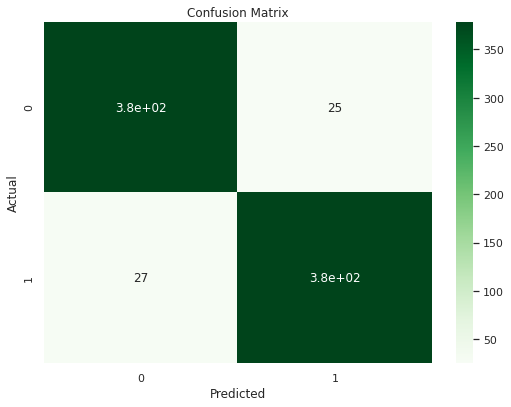

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       403
           1       0.94      0.93      0.94       404

    accuracy                           0.94       807
   macro avg       0.94      0.94      0.94       807
weighted avg       0.94      0.94      0.94       807



In [457]:
base_model_dtc = tree.DecisionTreeClassifier()
base_model_dtc.fit(train_features, train_targets)

evaluate_model(base_model_dtc)


Model Accuracy:
Precision on training data: 0.937
Precision on testing data: 0.942
Accuracy on test data: 0.949


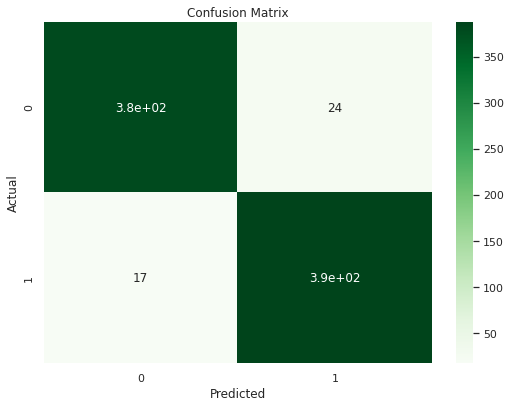

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       403
           1       0.94      0.96      0.95       404

    accuracy                           0.95       807
   macro avg       0.95      0.95      0.95       807
weighted avg       0.95      0.95      0.95       807



In [458]:
best_random_dtc = dtc_random.best_estimator_

evaluate_model(best_random_dtc)


#### Random Forest

In [465]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
ccp_alpha = [2**i for i in range(-10,0)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha}

random_grid

{'bootstrap': [True, False],
 'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [466]:
rfc = RandomForestClassifier()

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [467]:
rfc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [468]:
rfc_random.best_params_


{'bootstrap': True,
 'ccp_alpha': 0.0078125,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.961
Accuracy on test data: 0.952


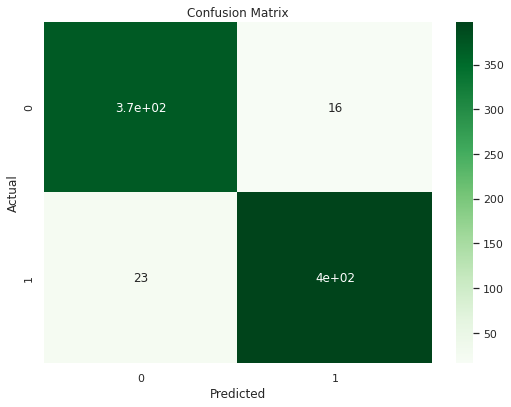

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       387
           1       0.96      0.95      0.95       420

    accuracy                           0.95       807
   macro avg       0.95      0.95      0.95       807
weighted avg       0.95      0.95      0.95       807



In [470]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                    oob_score = True)
base_model.fit(train_features, train_targets)

evaluate_model(base_model)


Model Accuracy:
Precision on training data: 0.946
Precision on testing data: 0.968
Accuracy on test data: 0.943


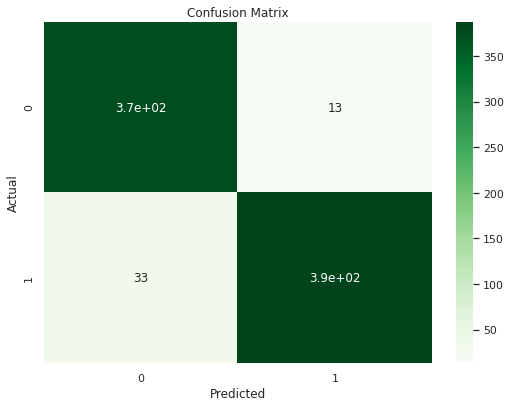

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       387
           1       0.97      0.92      0.94       420

    accuracy                           0.94       807
   macro avg       0.94      0.94      0.94       807
weighted avg       0.94      0.94      0.94       807



In [471]:
best_random = rfc_random.best_estimator_

evaluate_model(best_random)


### Prediction for the new stars

In [472]:
# descriptive stats
all_stars_filtered.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_3766_center
count,8.849200e+04,8.849200e+04,8.849200e+04,88492.0,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.000000,88492.0,88492.000000,88485.000000,88485.000000,88492.000000,88492.000000,88492.000000,...,8.557700e+04,8.557700e+04,85577.000000,85577.000000,85559.000000,88492.000000,85559.000000,85575.000000,85577.000000,1269.000000,1269.000000,88492.000000,1269.000000,1269.000000,1269.000000,88492.000000,88492.000000,88492.000000,88492.000000,47884.000000,47884.000000,47884.000000,47884.000000,23601.000000,23601.000000,23601.000000,23601.000000,23601.000000,23601.000000,26577.0,26577.000000,26577.000000,26577.000000,26577.000000,26577.000000,26577.000000,88492.000000,88492.000000,88492.000000,88492.000000
mean,1.635721e+18,5.334944e+18,8.462535e+08,2015.5,174.087411,0.096373,-61.525161,0.091111,0.696391,0.117785,9.220138,-7.630639,0.199143,1.713202,0.167360,-0.015591,-0.132323,-0.352467,0.007184,0.173277,0.055937,-0.207725,0.189009,0.139879,-0.011168,261.742530,6.324459,260.322639,1.419891,3.171744,536.167236,0.311542,9.140319,31.0,14.669279,1.496958,0.024316,-0.009564,29.917371,16.996700,...,2.982186e+04,1.223609e+02,289.889771,15.878297,1.403201,0.092799,1.379788,0.548903,0.830849,-0.621799,1.773304,0.076549,4979.354004,3.258471,-0.042553,294.106924,0.050690,212.714851,-55.692693,100108.470053,5050.312012,4845.702637,5345.553711,1.049514,0.805981,1.338835,0.520819,0.397866,0.668173,200111.0,3.116315,2.788340,3.368828,16.138004,13.290249,18.985895,0.526834,85.209951,26.082106,0.527082
std,0.000000e+00,7.299506e+14,4.880187e+08,0.0,0.844151,0.126478,0.380858,0.117002,0.815288,0.149910,12.404838,5.599557,0.276544,3.472840,0.220609,0.091203,0.099980,0.129382,0.103150,0.098597,0.102539,0.154101,0.114297,0.107678,0.129417,29.914756,39.003592,29.953723,2.126294,11.853771,4595.695312,0.769559,133.426016,0.0,43.946407,0.102226,0.030079,0.063537,3.339600,1.429264,...,1.542183e+06,1.127505e+04,304.695343,1.512971,0.284002,0.366802,0.457142,0.288054,0.267850,25.024655,2.609303,0.697986,596.625854,0.471356,0.249134,0.403301,0.379758,0.705252,0.385964,450.892567,927.264343,896.097839,956.622009,0.632642,0.621306,0.680121,0.317833,0.309767,0.345479,0.0,6.503063,5.872905,7.142126,369.527130,297.474701,442.826660,0.192229,95.989096,41.975123,0.192407
min,1.635721e+18,5.333378e+18,1.780800e+04,2015.5,172.392181,0.011657,-62.414053,0.011804,0.06

In [473]:
# chosing only GAIA stars close to 0.40 degree radius of the center
all_stars_filtered = all_stars_filtered.dropna(subset = feature_columns)
GAIA_target_stars = all_stars_filtered[all_stars_filtered['dist_3766_center'] <= 0.40]

In [475]:
# removing the member stars from GAIA data
GAIA_target_stars = pd.concat([GAIA_target_stars, training_data.drop(columns=['PMemb', 'member']), 
                               training_data.drop(columns=['PMemb', 'member'])]).drop_duplicates(keep=False)

In [476]:
# select the set of predictor variables from the new dataset
new_features = GAIA_target_stars.loc[:, feature_columns]
new_features = new_features.astype('float32')

In [477]:
# train the model again using all the features and targets of the previous dataset
# rfc.fit(features, targets)

In [478]:
# estimate the membership classification of the stars
GAIA_target_stars['member'] = best_random.predict(new_features)
GAIA_target_stars['member'].value_counts()

0    20746
1      828
Name: member, dtype: int64

In [479]:
# estimate the membership probability of the stars
GAIA_target_stars['PMemb'] = best_random.predict_proba(new_features)[:,1]
sum(GAIA_target_stars['PMemb'] >= 0.5)

828

In [552]:
potentialMember = GAIA_target_stars[GAIA_target_stars['member'] == 1]
len(potentialMember)

828

In [485]:
potentialMember.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_3766_center,member,PMemb
count,8.280000e+02,8.280000e+02,8.280000e+02,828.0,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.0,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,...,808.000000,808.000000,807.000000,828.000000,807.000000,807.000000,808.000000,2.000000,2.000000,828.000000,2.000000,2.00000,2.0,828.000000,828.000000,828.000000,828.000000,497.000000,497.000000,497.000000,497.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,355.0,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,828.000000,828.000000,828.000000,828.000000,828.0,828.000000
mean,1.635721e+18,5.334879e+18,8.664464e+08,2015.5,174.104005,0.057966,-61.599802,0.056686,0.443210,0.070520,9.081001,-6.710555,0.115078,0.955930,0.104416,-0.007597,-0.128404,-0.381686,-0.001068,0.170038,0.048664,-0.300879,0.183738,0.135562,0.015427,266.144928,10.258454,264.743961,1.400966,1.257283,308.211792,0.082262,1.224947,31.0,19.802937,1.547394,0.014730,-0.001016,30.346618,16.868357,...,307.843201,15.632066,1.308911,0.064010,1.129240,0.448860,0.680755,5.435351,1.386662,0.016908,5250.000000,3.75000,0.0,294.135433,-0.016775,212.816199,-55.740265,100137.891348,5784.331543,5528.875488,6095.122559,0.906406,0.630301,1.167686,0.448891,0.310875,0.581358,200111.0,2.239105,2.028564,2.428880,63.319939,53.105579,73.534271,0.302455,86.732895,12.683328,0.302492,1.0,0.777271
std,0.000000e+00,7.489140e+14,4.806607e+08,0.0,0.458849,0.035351,0.225348,0.033033,0.070409,0.041902,6.000494,0.436813,0.071003,0.308332,0.062095,0.089198,0.099824,0.109240,0.105887,0.106673,0.103039,0.130102,0.100655,0.103330,0.117759,28.247580,49.171746,28.204078,1.816517,4.847138,266.560944,0.155981,7.271492,0.0,51.023819,0.086382,0.008897,0.065258,3.103129,1.214907,...,294.206177,1.451073,0.122368,0.294257,0.414360,0.204301,0.233448,2.376970,1.514416,0.357614,353.553406,1.06066,0.0,0.220312,0.223324,0.398815,0.219147,505.483484,1302.706055,1223.522583,1354.723877,0.453899,0.426418,0.495528,0.227425,0.211576,0.250895,0.0,4.410867,4.279086,4.641055,1092.439697,915.799988,1269.079224,0.084965,56.257639,8.732675,0.084983,0.0,0.137153
min,1.635721e+18,5.334126e+18,9.754970e+05,2015.5,173.243674,0.012594,-62.009758,0.013827,0.333849,0.016164,3.008756,-7.498698,0.023865,0.138207,0.025005,-0.778783,-0.742463,-0.915828,-0.457533,-0.229285,-0.325204,-0.679248,-0.280185,-0.346029,-0.775599,128.000000,0.000000,127.000000,0.000000,-7.739281,108.809547,0.000000,0.000000,

In [486]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_3766_center,member
count,1.345000e+03,1.345000e+03,1.345000e+03,1345.0,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.0,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,...,1332.000000,1332.000000,1332.000000,1345.000000,1332.000000,1332.000000,1332.000000,7.000000,7.000000,1345.000000,7.000000,7.000000,7.0,1345.000000,1345.000000,1345.000000,1345.000000,1124.000000,1124.000000,1124.000000,1124.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,645.0,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,1345.000000,1345.000000,1345.000000,1345.0,1345.000000,1345.0
mean,1.635721e+18,5.334609e+18,8.424531e+08,2015.5,174.069570,0.043488,-61.605326,0.040766,0.451516,0.051044,11.389517,-6.729265,0.085252,0.989706,0.076118,0.004484,-0.117640,-0.427358,0.005188,0.174022,0.056509,-0.326855,0.162926,0.191589,0.023870,238.846840,32.005948,237.107063,1.739777,2.201549,312.656036,0.048518,1.378081,31.0,47.825153,1.608523,0.010429,-0.013727,27.389591,16.869145,...,416.553314,14.584754,1.264339,0.086989,0.831568,0.315800,0.515768,-4.501915,0.673221,0.047584,4328.571289,3.428571,0.0,294.121187,-0.026219,212.801672,-55.755764,100202.161922,6623.167480,6306.059082,6925.103027,0.760011,0.492358,1.004757,0.378493,0.242183,0.500143,200111.0,3.075979,2.817126,3.384270,77.577660,67.863472,87.291855,0.139323,102.326219,16.470604,1.0,0.139332,1.0
std,0.000000e+00,6.676445e+14,4.857395e+08,0.0,0.240581,0.023430,0.115405,0.021349,0.059907,0.027003,5.637852,0.271107,0.045445,0.247746,0.040575,0.090899,0.111030,0.112825,0.103957,0.107163,0.096844,0.137262,0.106514,0.109707,0.113991,37.037952,77.736879,36.979911,2.673019,6.167279,276.595795,0.111442,7.595787,0.0,82.410362,0.098359,0.005612,0.061237,4.107544,1.523372,...,319.959290,1.801677,0.098499,0.302301,0.468737,0.218305,0.266216,14.147385,0.490243,0.738480,576.524902,0.731925,0.0,0.115599,0.114211,0.207730,0.112881,601.754838,1747.951538,1637.770142,1764.354858,0.325226,0.299551,0.367508,0.161831,0.147235,0.185739,0.0,19.736931,18.306589,22.103130,1102.031494,963.601929,1240.878418,0.084134,50.487480,8.391206,0.0,0.084147,0.0
min,1.635721e+18,5.334149e+18,4.126710e+05,2015.5,173.417127,0.013413,-61.910596,0.014418,0.332896,0.016530,3.019621,-7.712736,0.025638,0.141068,0.025679,-0.344106,-0.516385,-0.860898,-0.339244,-0.238388,-0.379649,-0.773552,-0.354136,-0.162664,-0.573144,98.000000,0.000000,98.00000

#### Visualization

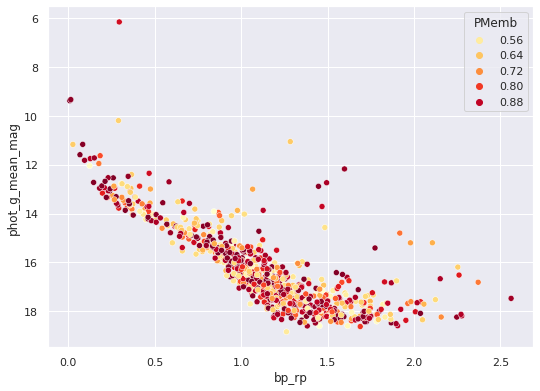

In [480]:
# CMD of predicted members 

cmd = sns.scatterplot(x = 'bp_rp', y = 'phot_g_mean_mag', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
cmd.invert_yaxis()

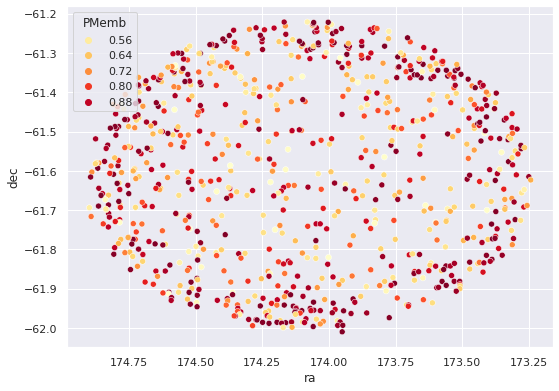

In [481]:
skyplot = sns.scatterplot(x = 'ra', y = 'dec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
skyplot.invert_xaxis()

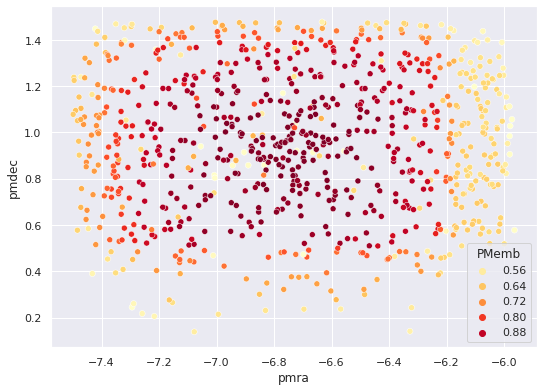

In [482]:
# pm plot
sns.scatterplot(x = 'pmra', y = 'pmdec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )


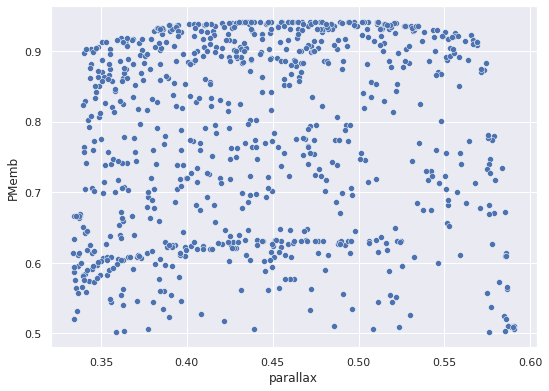

In [483]:
# parallax plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )

In [490]:
# saving the files as csv
# all_stars.to_csv('gaia_3766_membership_prob.csv')

potentialMember.to_csv('NGC_3766_membership_prob.csv')


### Comparing the old and new predicted members

In [491]:
# creating subset for the potential member in previous dataset

concatenated = pd.concat([potentialMember.assign(dataset='New_member'), member.assign(dataset='Old_member')])


In [492]:
concatenated

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,dist_3766_center,member,PMemb,dataset
338,1635721458409799680,Gaia DR2 5334208407957638272,5334208407957638272,802944951,2015.5,174.039949,0.058612,-61.607646,0.056858,0.586519,0.072502,8.089740,-6.489173,0.123566,0.848730,0.109688,0.033271,-0.278224,-0.187147,-0.180648,0.076126,-0.083357,-0.403754,0.061030,0.274418,-0.083522,173,0,172,1,-1.719373,136.922104,0.000000,0.000000,31,False,4.546117,1.541758,0.014532,-0.090617,...,NaN,NaN,0.983673,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.108313,-0.032276,212.786521,-55.767333,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.018223,52.515698,7.737672,0.018217,1,0.563154,New_member
766,1635721458409799680,Gaia DR2 5334206689970688768,5334206689970688768,562810260,2015.5,174.078630,0.149676,-61.641407,0.132298,0.568788,0.172745,3.292653,-6.579990,0.301228,1.120797,0.287315,0.085105,-0.196737,-0.298064,0.004164,0.005124,0.040176,-0.057365,0.301056,0.177107,0.167448,176,0,174,2,2.561639,219.809967,0.391231,1.030532,31,False,0.628552,1.513033,0.039376,0.129987,...,1.563856,0.569481,0.994375,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.135607,-0.059345,212.851970,-55.778400,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.026460,21.843851,3.900933,0.026463,1,0.908125,New_member
1322,1635721458409799680,Gaia DR2 5334208133079719040,5334208133079719040,434257841,2015.5,174.130123,0.021635,-61.637112,0.019780,0.394277,0.025434,15.501984,-7.128697,0.045157,0.437362,0.037572,0.072761,-0.107911,-0.392961,-0.075566,0.148517,-0.022163,-0.316381,0.268447,0.168135,0.035284,216,0,216,0,3.271853,284.786804,0.103227,2.181580,31,False,41.375767,1.692942,0.005291,0.047827,...,0.451794,0.152245,0.299549,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.157815,-0.048230,212.877508,-55.758142,100001,7703.000000,7423.333496,7965.000000,1.0020,0.7266,1.1695,0.5185,0.3920,0.6208,200111,2.223898,2.079999,2.394621,15.687874,13.125473,18.250275,https://gea.esac.esa.int/data-server/datalink/...,,0.034273,157.863227,11.640774,0.034273,1,0.739011,New_member
1694,1635721458409799680,Gaia DR2 5334206930488832000,5334206930488832000,902789955,2015.5,174.029025,0.021929,-61.646821,0.022224,0.486095,0.029137,16.682817,-6.697493,0.061479,1.437520,0.048750,-0.011897,0.189742,-0.077748,-0.011686,0.154882,0.081936,-0.313348,0.360471,-0.088097,-0.273432,166,0,166,0,0.856073,176.146637,0.000000,0.000000,31,False,73.486725,1.713391,0.004948,-0.088797,...,0.341888,0.109204,0.232684,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,294.114591,-0.071291,212.828973,-55.798825,100001,8369.500000,8036.333496,8802.000000,0.7670,0.6140,0.8850,0.3688,0.3029,0.4281,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...

In [493]:
concatenated.dataset.value_counts()

Old_member    1345
New_member     828
Name: dataset, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

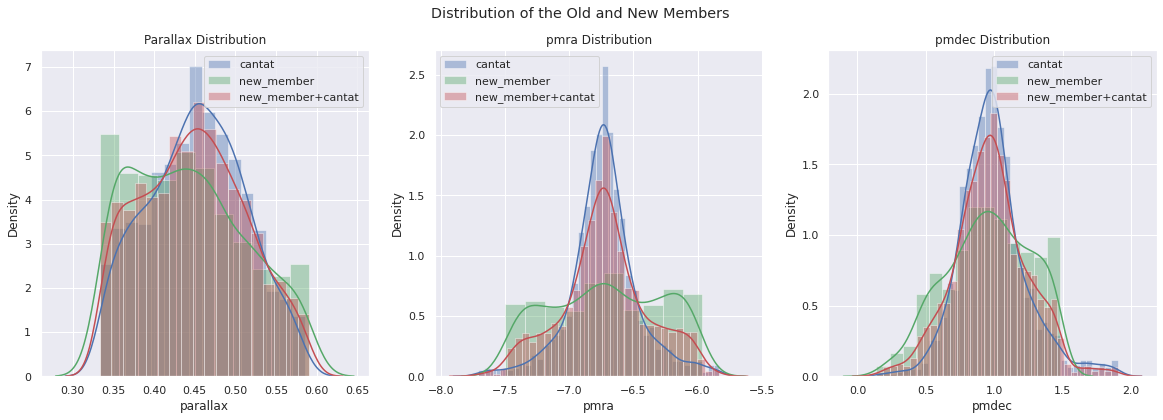

In [560]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Distribution of the Old and New Members')


sns.distplot(member['parallax'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[0])
sns.distplot(potentialMember['parallax'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[0])
sns.distplot(concatenated['parallax'], color = 'r', ax=axes[0], kde=True,
             label = 'new_member+cantat')
axes[0].set_title('Parallax Distribution')
axes[0].legend()

sns.distplot(member['pmra'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[1])
sns.distplot(potentialMember['pmra'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[1])
sns.distplot(concatenated['pmra'], color = 'r', ax=axes[1], kde=True,
             label = 'new_member+cantat')
axes[1].set_title('pmra Distribution')
axes[1].legend()

sns.distplot(member['pmdec'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[2])
sns.distplot(potentialMember['pmdec'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[2])
sns.distplot(concatenated['pmdec'], color = 'r', ax=axes[2], kde=True,
             label = 'new_member+cantat')
axes[2].set_title('pmdec Distribution')
axes[2].legend()

plt.show()


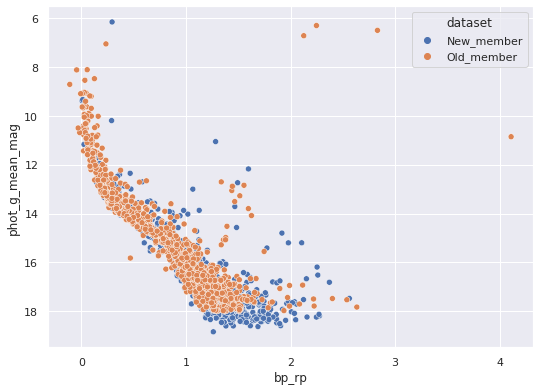

In [494]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset')
cmd.invert_yaxis()

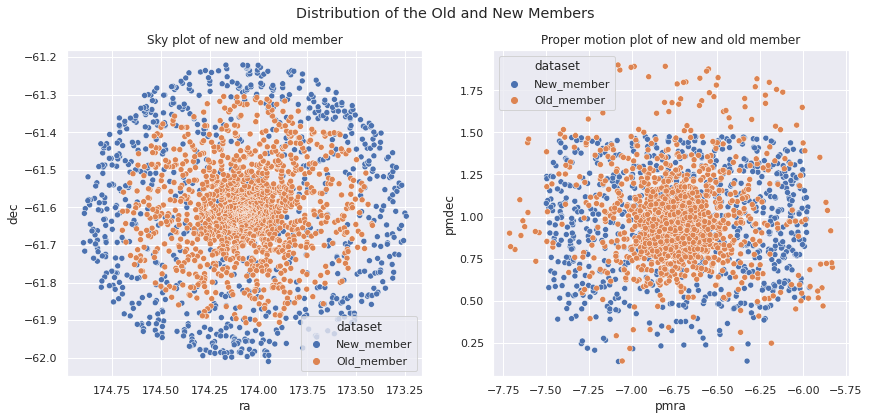

In [558]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Distribution of the Old and New Members')

skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                hue='dataset', ax=axes[0])
skyplot.invert_xaxis()
axes[0].set_title('Sky plot of new and old member')

# proper motion plot
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                hue='dataset', ax=axes[1])
axes[1].set_title('Proper motion plot of new and old member')

plt.show()

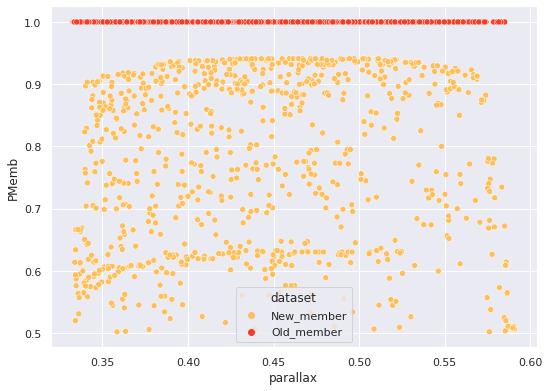

In [498]:
# parallax vs PMemb plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  hue = 'dataset',
                      palette='YlOrRd', data = concatenated )

In [499]:
# pd_prof.ProfileReport(potentialMember)

In [500]:
#files.download('NGC_3766_cantat.csv')

#files.download('NGC_3766_membership_prob.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


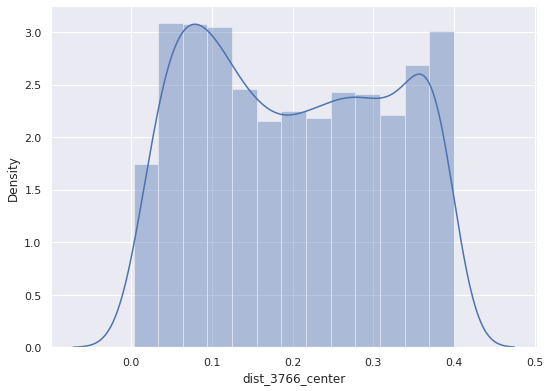

In [501]:
sns.distplot(concatenated['dist_3766_center'])

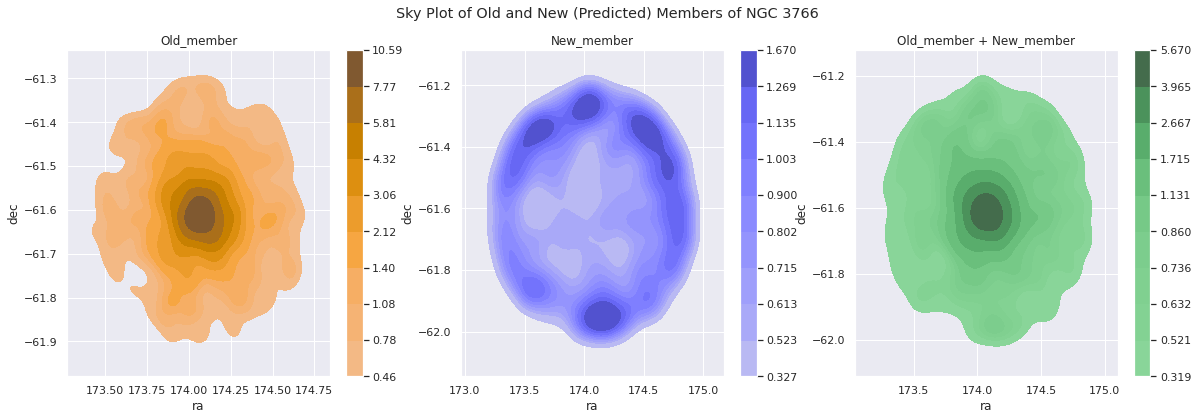

In [528]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Sky Plot of Old and New (Predicted) Members of NGC 3766')

sns.kdeplot(x='ra', y='dec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='ra', y='dec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='ra', y='dec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

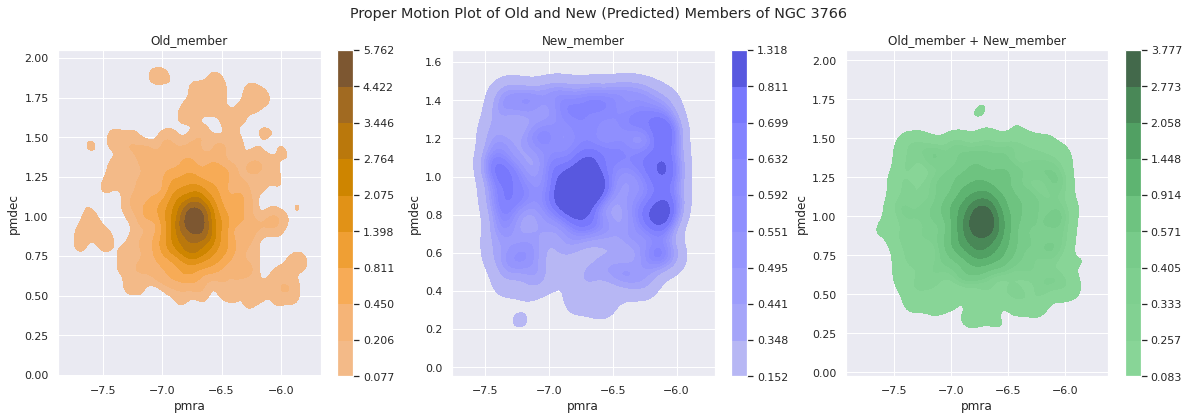

In [527]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Proper Motion Plot of Old and New (Predicted) Members of NGC 3766')

sns.kdeplot(x='pmra', y='pmdec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='pmra', y='pmdec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='pmra', y='pmdec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()